In [1]:
import nibabel as nib
import numpy as np
import os
import glob
import sys
import SimpleITK as sitk
# !{sys.executable} -m pip install seaborn --user
abs_dir="/mnt/data/mranzini"
# abs_dir="/Users/Marta/Desktop/mountpoint"
sys.path.append(os.path.join(*[abs_dir, "Code", "Demic-v0.1"]))
import pandas as pd
from Demic.util.image_process import *
# from Demic.image_io.file_read_write import *

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def compute_dice(seg1, seg2, label=1.0):
    # flatten the segmentations
    seg1 = seg1.flatten()
    seg2 = seg2.flatten()

    if len(seg1) != len(seg2):
        raise InputError('The two segmentations have different dimensions - not comparable!')

    yt = np.asarray(seg1 == label, np.float32)
    yp = np.asarray(seg2 == label, np.float32)
    
    intersection = np.multiply(yt, yp)
    union = np.asarray(yt + yp > 0, np.float32)
    dice = 2 * np.sum(intersection) / (np.sum(yt) + np.sum(yp) + 1e-10)
    
    return dice 

In [3]:
def compute_accuracy(seg1, seg2, label=1.0):
    # flatten the segmentations
    seg1 = seg1.flatten()
    seg2 = seg2.flatten()

    if len(seg1) != len(seg2):
        raise InputError('The two segmentations have different dimensions - not comparable!')

    yt = (seg1 == label)
    yp = (seg2 == label)

    TP = np.sum(np.logical_and(yt == 1, yp == 1))  # True positives
    TN = np.sum(np.logical_and(yt == 0, yp == 0))  # True negatives
    FP = np.sum(np.logical_and(yt == 0, yp == 1))  # False positives
    FN = np.sum(np.logical_and(yt == 1, yp == 0))  # False negatives
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)

In [4]:
def percentage_dice_and_accuracy(seg1, seg2, dice_thr=0.9, bg_thr=0.999, nr_min_pixels=40):
    nr_slices = np.shape(seg1)[0]
    all_slices = np.empty(nr_slices)
    for i in range(0, nr_slices):
        temp_seg1 = seg1[i, ...]
        temp_seg2 = seg2[i, ...]
        
        # if the foreground segmentation is empty in the GT, or very little foregroun
        # compute the the Dice for the background
        if np.all(temp_seg1 == 0) or np.sum(temp_seg1) <= nr_min_pixels:
            accuracy = compute_dice(temp_seg1, temp_seg2, label=0.0)
#             print(f"accuracy = {accuracy}")
            all_slices[i] = 1 if accuracy >= bg_thr else 0
        # else consider the dice of the foreground
        else:
            dice = compute_dice(temp_seg1, temp_seg2, label=1.0)
#             print(f"dice = {dice}")
            all_slices[i] = 1 if dice >= dice_thr else 0
            
    # compute the percentage of slices with dice above the threshold
    nr_good_slices = np.count_nonzero(all_slices)
    percentage = 100 *  nr_good_slices / nr_slices
    
    return percentage

In [5]:
def load_nifty_volume_as_4d_array(filename):
    img_obj = sitk.ReadImage(filename)
    data_array = sitk.GetArrayFromImage(img_obj)
    spacing = img_obj.GetSpacing()
    direction = img_obj.GetDirection()
    shape = data_array.shape
    if(len(shape) == 4):
        data_array = np.moveaxis(data_array, 0, -1) 
    elif(len(shape) == 3):
        data_array = np.expand_dims(data_array, axis = -1)
    else:
        raise ValueError("unsupported image dim: {0:}".format(len(shape)))
    output = {}
    output['data_array'] = data_array
    output['spacing']    = (spacing[2], spacing[1], spacing[0])
    output['direction']  = direction
    return output

In [6]:
def read_nifti(nifti_file):
#     img_nii = nib.load(nifti_file)
#     img = img_nii.get_fdata()
    
    img_dict = load_nifty_volume_as_4d_array(nifti_file)
    img = img_dict['data_array']
    
    # if two channels, get the foreground one
    if img.shape[3] > 1:
        img = img[..., 1]
        
    return img

In [7]:
def apply_post_processing(input_pred, pred_thr=0.5):
    
    strt = ndimage.generate_binary_structure(3,2) # iterate structure
    input_pred = input_pred > pred_thr   # TODO: check that this step is actually needed - Guotai did not have but need to check what activation he had in final layer
    post_mask = ndimage.morphology.binary_closing(input_pred, strt)
    post_mask = get_largest_component(post_mask)
    postprocessed = np.asarray(post_mask*input_pred, np.uint8)

    return postprocessed

In [12]:
def get_all_dice(group="GroupA", remove_outliers=False, 
                dice_thr=0.9, bg_thr=0.999, nr_min_pixels=40):

    MAIN_DIR = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "Retraining_with_expanded_dataset"])
    folder_segment_guotai = os.path.join(*[MAIN_DIR, "inference", "guotai"])
    folder_segment_retrained = os.path.join(*[MAIN_DIR, "inference", "expanded"])
    folder_dynUnet = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "FBS_Monai",
                                "basic_unet_monai", "tests_deterministic_seeds", "monai0.3.0_tests",
                                 "2020-10-08_09-47-58_monai0.3.0-MONAI_dynUNet_inplanespacing_continue", 
                                 "inference_valid_key_metric=0.9458"])
    folder_dynunet_postproc = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "FBS_Monai",
                                "basic_unet_monai", "tests_deterministic_seeds", "monai0.3.0_tests",
                                 "2020-10-08_09-47-58_monai0.3.0-MONAI_dynUNet_inplanespacing_continue", 
                                 "inference_valid_postproc_key_metric=0.9458"])
    
    folder_gt1 = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "Data", "NeuroImage_dataset"])
    folder_gt2 = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "Data", "NeuroImage_dataset_extension"])

    params_dict = {'GroupA': os.path.join(folder_gt1, "list_inference_h_subjects.txt"),
                  'GroupB1': os.path.join(folder_gt1, "list_inference_p1_subjects.txt"),
                  'GroupB2': os.path.join(folder_gt1, "list_inference_p2_subjects.txt"),
                  'GroupC': os.path.join(*[folder_gt2, "splitting_list", "list_inference_C.txt"]),
                  'GroupD': os.path.join(*[folder_gt2, "splitting_list", "list_inference_D.txt"]),
                  'GroupE': os.path.join(*[folder_gt2, "splitting_list", "list_inference_E.txt"]),
                  'GroupF': os.path.join(*[folder_gt2, "splitting_list", "list_inference_F.txt"])
                  }
    
    gt_dict = {'GroupA': folder_gt1,
               'GroupB1': folder_gt1,
               'GroupB2': folder_gt1,
               'GroupC': folder_gt2,
               'GroupD': folder_gt2,
               'GroupE': folder_gt2,
               'GroupF': folder_gt2}

    dice_vals = {"subj_id": [], "guotai": [], "expanded": [], "dynUnet": [], "dynUnet_postproc": []}
    subj_list = params_dict[group]
    folder_gt = gt_dict[group]
    with open(subj_list) as r:
        lines = r.readlines()
        for l in lines:
            print(l)
            all_stacks = sorted(glob.glob(os.path.join(*[folder_gt, group, l.rstrip() + '*_Label.nii.gz'])))
            for s in all_stacks:
                scan_id = os.path.basename(s)
                scan_id = scan_id.split("_Label", 1)[0]
                if scan_id == "b79_16":
                    # original image is corrupted
                    continue
                dice_vals["subj_id"].append(scan_id)
                
                # get the ground truth
                gt = np.squeeze(read_nifti(s))
                
                # extract dice from Guotai's model
                guotai_file = os.path.join(*[folder_segment_guotai, group, scan_id + "_segment.nii.gz"])
                guotai_segment = np.squeeze(read_nifti(guotai_file))
#                 if(remove_outliers):
                # always apply post-processing for guotai's models
                guotai_segment = apply_post_processing(guotai_segment)
                dice_vals["guotai"].append(percentage_dice_and_accuracy(gt, guotai_segment, 
                                                                        dice_thr=dice_thr, bg_thr=bg_thr,
                                                                        nr_min_pixels=nr_min_pixels))
                
                # extract dice from expanded training model
                retrained_file = os.path.join(*[folder_segment_retrained, group, scan_id + "_segment.nii.gz"])
                retrained_segment = np.squeeze(read_nifti(retrained_file))
#                 if(remove_outliers):
                # always apply post-processing for guotai's models
                retrained_segment = apply_post_processing(retrained_segment)
                dice_vals["expanded"].append(percentage_dice_and_accuracy(gt, retrained_segment, 
                                                                          dice_thr=dice_thr, bg_thr=bg_thr,
                                                                          nr_min_pixels=nr_min_pixels))
                
                # extract dice from basic unet in monai
                monai_dyn_file = os.path.join(*[folder_dynUnet, scan_id + "_Image", scan_id + "_Image_seg.nii.gz"])
                monai_dyn_segment = np.squeeze(read_nifti(monai_dyn_file))
                if(remove_outliers):
                    monai_dyn_segment = apply_post_processing(monai_dyn_segment)
                monai_dyn_segment = monai_dyn_segment > 0.05
                dice_vals["dynUnet"].append(percentage_dice_and_accuracy(gt, monai_dyn_segment, 
                                                                         dice_thr=dice_thr, bg_thr=bg_thr,
                                                                         nr_min_pixels=nr_min_pixels))
                
                # extract dice from basic unet in monai
                monai_dynpost_file = os.path.join(*[folder_dynunet_postproc, scan_id + "_Image", scan_id + "_Image_seg.nii.gz"])
                monai_dynpost_segment = np.squeeze(read_nifti(monai_dynpost_file))
                dice_vals["dynUnet_postproc"].append(percentage_dice_and_accuracy(gt, monai_dynpost_segment, 
                                                                                  dice_thr=dice_thr, bg_thr=bg_thr,
                                                                                  nr_min_pixels=nr_min_pixels))
                

    dice_vals["guotai"] = np.asarray(dice_vals["guotai"])
    dice_vals["expanded"] = np.asarray(dice_vals["expanded"])
    dice_vals["dynUnet"] = np.asarray(dice_vals["dynUnet"])
    dice_vals["dynUnet_postproc"] = np.asarray(dice_vals["dynUnet_postproc"])

    return dice_vals

In [13]:
def extract_metric_values(dice_thr=0.9, bg_thr=0.999, nr_min_pixels=40, remove_outlier=False):
    dice_groupA = get_all_dice(group="GroupA", remove_outliers=remove_outlier, dice_thr=dice_thr, 
                               bg_thr=bg_thr, nr_min_pixels=nr_min_pixels)
    dice_groupB1 = get_all_dice(group="GroupB1", remove_outliers=remove_outlier, dice_thr=dice_thr, 
                               bg_thr=bg_thr, nr_min_pixels=nr_min_pixels)
    dice_groupB2 = get_all_dice(group="GroupB2", remove_outliers=remove_outlier, dice_thr=dice_thr, 
                               bg_thr=bg_thr, nr_min_pixels=nr_min_pixels)
    dice_groupC = get_all_dice(group="GroupC", remove_outliers=remove_outlier, dice_thr=dice_thr, 
                               bg_thr=bg_thr, nr_min_pixels=nr_min_pixels)
    dice_groupD = get_all_dice(group="GroupD", remove_outliers=remove_outlier, dice_thr=dice_thr, 
                               bg_thr=bg_thr, nr_min_pixels=nr_min_pixels)
    dice_groupE = get_all_dice(group="GroupE", remove_outliers=remove_outlier, dice_thr=dice_thr, 
                               bg_thr=bg_thr, nr_min_pixels=nr_min_pixels)
    dice_groupF = get_all_dice(group="GroupF", remove_outliers=remove_outlier, dice_thr=dice_thr, 
                               bg_thr=bg_thr, nr_min_pixels=nr_min_pixels)
    return dice_groupA, dice_groupB1, dice_groupB2, dice_groupC, dice_groupD, dice_groupE, dice_groupF

# COMPARE USE vs NO USE OF POST PROCESSING

In [14]:
import pandas as pd
thr_fg = 0.9
thr_bg = 0.999

dice_groupA, dice_groupB1, dice_groupB2, dice_groupC, dice_groupD, dice_groupE, dice_groupF = extract_metric_values(dice_thr=thr_fg,
                                                                                                                   bg_thr=thr_bg,
                                                                                                                   remove_outlier=False)

ylabel = "% of accepted slices"
fig_title = "FG Dice>=0.9, BG acc >=0.999"


a02

a06

a17

a24

a26

b18

b79

17_05

17_10

17_14

17_16

17_18

17_20

17_25

17_34

17_36

17_38

17_43

17_49

17_51

17_53

17_57

17_66

17_06

17_11

17_15

17_17

17_19

17_21

17_26

17_35

17_37

17_39

17_44

17_50

17_52

17_54

17_58

17_67

C01

C07

C08

C17

C22

D01

D05

E07

E08

E16

E17

F01

F02

F03

F04



KeyError: 'dynUnet_post'

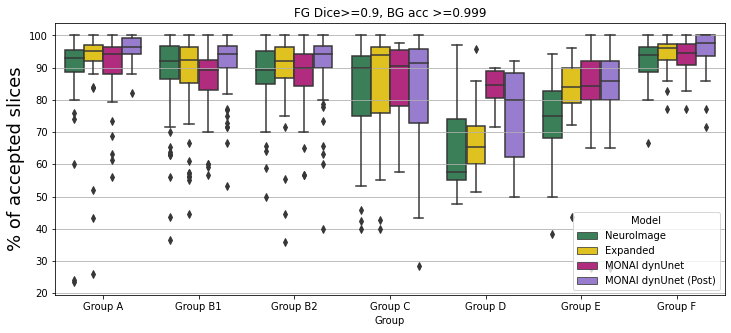

In [15]:
pd1 = pd.DataFrame(data={'Group': 'Group A', 'Dice': dice_groupA['guotai'], 'Model': 'NeuroImage'})
pd1 = pd1.append(pd.DataFrame({'Group': 'Group A', 'Dice': dice_groupA['expanded'], 'Model': 'Expanded'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B1', 'Dice': dice_groupB1['guotai'], 'Model': 'NeuroImage'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B1', 'Dice': dice_groupB1['expanded'], 'Model': 'Expanded'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B2', 'Dice': dice_groupB2['guotai'], 'Model': 'NeuroImage'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B2', 'Dice': dice_groupB2['expanded'], 'Model': 'Expanded'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group C', 'Dice': dice_groupC['guotai'], 'Model': 'NeuroImage'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group C', 'Dice': dice_groupC['expanded'], 'Model': 'Expanded'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group D', 'Dice': dice_groupD['guotai'], 'Model': 'NeuroImage'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group D', 'Dice': dice_groupD['expanded'], 'Model': 'Expanded'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group E', 'Dice': dice_groupE['guotai'], 'Model': 'NeuroImage'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group E', 'Dice': dice_groupE['expanded'], 'Model': 'Expanded'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group F', 'Dice': dice_groupF['guotai'], 'Model': 'NeuroImage'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group F', 'Dice': dice_groupF['expanded'], 'Model': 'Expanded'}))

pd1 = pd1.append(pd.DataFrame({'Group': 'Group A', 'Dice': dice_groupA['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B1', 'Dice': dice_groupB1['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B2', 'Dice': dice_groupB2['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group C', 'Dice': dice_groupC['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group D', 'Dice': dice_groupD['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group E', 'Dice': dice_groupE['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group F', 'Dice': dice_groupF['dynUnet'], 'Model': 'MONAI dynUnet'}))

pd1 = pd1.append(pd.DataFrame({'Group': 'Group A', 'Dice': dice_groupA['dynUnet_postproc'], 'Model': 'MONAI dynUnet (Post)'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B1', 'Dice': dice_groupB1['dynUnet_postproc'], 'Model': 'MONAI dynUnet (Post)'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B2', 'Dice': dice_groupB2['dynUnet_postproc'], 'Model': 'MONAI dynUnet (Post)'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group C', 'Dice': dice_groupC['dynUnet_postproc'], 'Model': 'MONAI dynUnet (Post)'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group D', 'Dice': dice_groupD['dynUnet_postproc'], 'Model': 'MONAI dynUnet (Post)'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group E', 'Dice': dice_groupE['dynUnet_postproc'], 'Model': 'MONAI dynUnet (Post)'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group F', 'Dice': dice_groupF['dynUnet_postproc'], 'Model': 'MONAI dynUnet (Post)'}))

fig = plt.figure(figsize=(12, 5))
# b1 = sns.boxplot(x='Group', y='Dice', hue='Model', data=pd1, 
#                  palette=['seagreen', 'gold', 'orangered', 'mediumvioletred', 'mediumpurple', 'lightblue'])
b1 = sns.boxplot(x='Group', y='Dice', hue='Model', data=pd1, 
                 palette=['seagreen', 'gold', 'mediumvioletred', 'mediumpurple'])
b1.set_ylabel(ylabel, fontsize=18)
b1.set_title(fig_title)
plt.grid(b=True,axis='y')

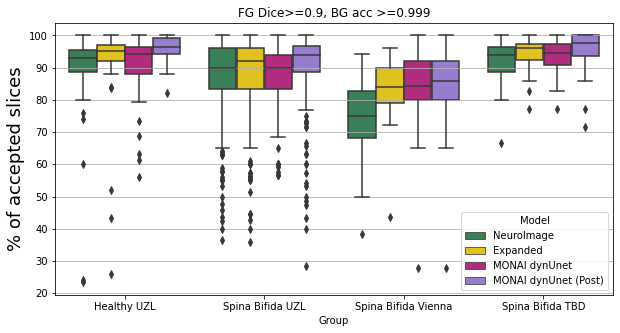

In [16]:
pd2 = pd.DataFrame(data={'Group': 'Healthy UZL', 'Dice': dice_groupA['guotai'], 'Model': 'NeuroImage'})
pd2 = pd2.append(pd.DataFrame({'Group': 'Healthy UZL', 'Dice': dice_groupA['expanded'], 'Model': 'Expanded'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB1['guotai'], 'Model': 'NeuroImage'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB1['expanded'], 'Model': 'Expanded'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB2['guotai'], 'Model': 'NeuroImage'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB2['expanded'], 'Model': 'Expanded'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupC['guotai'], 'Model': 'NeuroImage'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupC['expanded'], 'Model': 'Expanded'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupD['guotai'], 'Model': 'NeuroImage'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupD['expanded'], 'Model': 'Expanded'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida Vienna', 'Dice': dice_groupE['guotai'], 'Model': 'NeuroImage'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida Vienna', 'Dice': dice_groupE['expanded'], 'Model': 'Expanded'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida TBD', 'Dice': dice_groupF['guotai'], 'Model': 'NeuroImage'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida TBD', 'Dice': dice_groupF['expanded'], 'Model': 'Expanded'}))

pd2 = pd2.append(pd.DataFrame({'Group': 'Healthy UZL', 'Dice': dice_groupA['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB1['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB2['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupC['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupD['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida Vienna', 'Dice': dice_groupE['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida TBD', 'Dice': dice_groupF['dynUnet'], 'Model': 'MONAI dynUnet'}))

pd2 = pd2.append(pd.DataFrame({'Group': 'Healthy UZL', 'Dice': dice_groupA['dynUnet_postproc'], 'Model': 'MONAI dynUnet (Post)'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB1['dynUnet_postproc'], 'Model': 'MONAI dynUnet (Post)'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB2['dynUnet_postproc'], 'Model': 'MONAI dynUnet (Post)'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupC['dynUnet_postproc'], 'Model': 'MONAI dynUnet (Post)'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupD['dynUnet_postproc'], 'Model': 'MONAI dynUnet (Post)'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida Vienna', 'Dice': dice_groupE['dynUnet_postproc'], 'Model': 'MONAI dynUnet (Post)'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida TBD', 'Dice': dice_groupF['dynUnet_postproc'], 'Model': 'MONAI dynUnet (Post)'}))

fig2 = plt.figure(figsize=(10, 5))
# b2 = sns.boxplot(x='Group', y='Dice', hue='Model', data=pd2, palette=['seagreen', 'gold', 'orangered', 'mediumvioletred', 'mediumpurple', 'lightblue'])
b2 = sns.boxplot(x='Group', y='Dice', hue='Model', data=pd2, palette=['seagreen', 'gold', 'mediumvioletred', 'mediumpurple'])
b2.set_ylabel(ylabel, fontsize=18)
b2.set_title(fig_title)
plt.grid(b=True,axis='y')

NeuroImage
74
Expanded
59
MONAI dynUnet
66
MONAI dynUnet (Post)
39


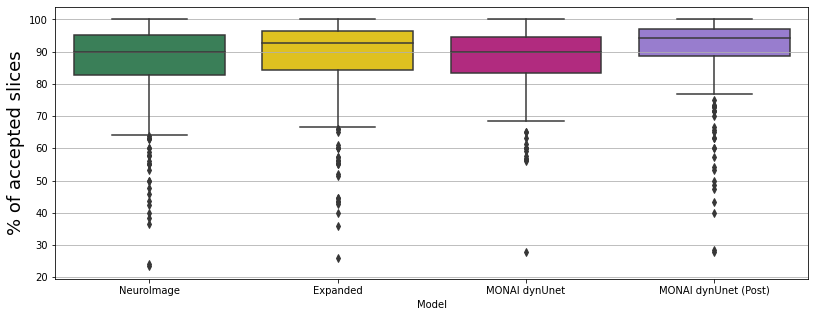

In [18]:
# boxplot overall
def append_all_data(which_key):
    all_dices = np.concatenate((dice_groupA[which_key],
                               dice_groupB1[which_key],
                               dice_groupB2[which_key],
                               dice_groupC[which_key],
                               dice_groupD[which_key],
                               dice_groupE[which_key],
                               dice_groupF[which_key]))
    return all_dices
    
pd3 = pd.DataFrame(data={'Model': 'NeuroImage', 'Dice': append_all_data('guotai')})
pd3 = pd3.append(pd.DataFrame(data={'Model': 'Expanded', 'Dice': append_all_data('expanded')}))
pd3 = pd3.append(pd.DataFrame(data={'Model': 'MONAI dynUnet', 'Dice': append_all_data('dynUnet')}))
pd3 = pd3.append(pd.DataFrame(data={'Model': 'MONAI dynUnet (Post)', 'Dice': append_all_data('dynUnet_postproc')}))

fig3 = plt.figure(figsize=(13.5, 5))
b3 = sns.boxplot(x='Model', y='Dice', data=pd3, 
                 palette=['seagreen', 'gold', 'mediumvioletred', 'mediumpurple'])
b3.set_ylabel(ylabel, fontsize=18)
b2.set_title(fig_title)
plt.grid(b=True,axis='y')

# print indexes of all Dices lower than 0.6
thr_ = 80
for k in ['NeuroImage', 'Expanded', 'MONAI dynUnet', 'MONAI dynUnet (Post)']:
    print(k)
    tmp_pd = pd3[pd3['Model'] == k]
    idx_dice = tmp_pd[tmp_pd['Dice'] <= thr_].index
    print(len(list(idx_dice)))

# COMPARE DIFFERENT CHOICES OF THRESHOLDS

Dealing with thr = 0.9
a02

a06

a17

a24

a26

b18

b79

17_05

17_10

17_14

17_16

17_18

17_20

17_25

17_34

17_36

17_38

17_43

17_49

17_51

17_53

17_57

17_66

17_06

17_11

17_15

17_17

17_19

17_21

17_26

17_35

17_37

17_39

17_44

17_50

17_52

17_54

17_58

17_67

C01

C07

C08

C17

C22

D01

D05

E07

E08

E16

E17

F01

F02

F03

F04

Dealing with thr = 0.99
a02

a06

a17

a24

a26

b18

b79

17_05

17_10

17_14

17_16

17_18

17_20

17_25

17_34

17_36

17_38

17_43

17_49

17_51

17_53

17_57

17_66

17_06

17_11

17_15

17_17

17_19

17_21

17_26

17_35

17_37

17_39

17_44

17_50

17_52

17_54

17_58

17_67

C01

C07

C08

C17

C22

D01

D05

E07

E08

E16

E17

F01

F02

F03

F04

Dealing with thr = 0.999
a02

a06

a17

a24

a26

b18

b79

17_05

17_10

17_14

17_16

17_18

17_20

17_25

17_34

17_36

17_38

17_43

17_49

17_51

17_53

17_57

17_66

17_06

17_11

17_15

17_17

17_19

17_21

17_26

17_35

17_37

17_39

17_44

17_50

17_52

17_54

17_58

17_67

C

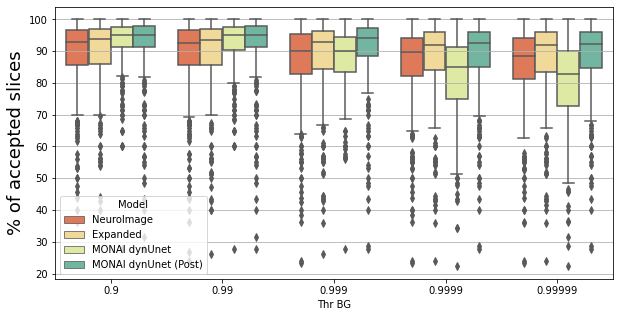

In [23]:
def make_pd_all_groups(dice_groupA, dice_groupB1, dice_groupB2, dice_groupC, dice_groupD, 
                       dice_groupE, dice_groupF, thr_bg=0.999, thr_fg=0.9):
    
    current_pd = pd.DataFrame(data={'Model': 'NeuroImage', 'Dice': append_all_data('guotai'), 
                              'Thr BG': thr_bg, 'Thr FG': thr_fg})
    current_pd = current_pd.append(pd.DataFrame(data={'Model': 'Expanded', 'Dice': append_all_data('expanded'), 
                                   'Thr BG': thr_bg, 'Thr FG': thr_fg}))
    current_pd = current_pd.append(pd.DataFrame(data={'Model': 'MONAI dynUnet', 'Dice': append_all_data('dynUnet'), 
                                   'Thr BG': thr_bg, 'Thr FG': thr_fg}))
    current_pd = current_pd.append(pd.DataFrame(data={'Model': 'MONAI dynUnet (Post)', 'Dice': append_all_data('dynUnet_postproc'), 
                                   'Thr BG': thr_bg, 'Thr FG': thr_fg}))
    
    return current_pd

# keep fixed the thr for the foreground and vary the thr for the background
t_fg = 0.9
for i, t_bg in enumerate((0.9, 0.99, 0.999, 0.9999, 0.99999)):
    print(f"Dealing with thr = {t_bg}")
    dice_groupA, dice_groupB1, dice_groupB2, dice_groupC, dice_groupD, dice_groupE, dice_groupF = extract_metric_values(dice_thr=t_fg,
                                                                                                                   bg_thr=t_bg,
                                                                                                                   remove_outlier=False)

    if i == 0:
        all_pd = make_pd_all_groups(dice_groupA, dice_groupB1, dice_groupB2, dice_groupC, 
                                    dice_groupD, dice_groupE, dice_groupF, thr_bg=t_bg, thr_fg=t_fg)
    else:
        all_pd = all_pd.append(make_pd_all_groups(dice_groupA, dice_groupB1, dice_groupB2, dice_groupC, 
                                    dice_groupD, dice_groupE, dice_groupF, thr_bg=t_bg, thr_fg=t_fg))

ylabel = "% of accepted slices"
fig_all = plt.figure(figsize=(10, 5))
b_bg = sns.boxplot(x='Thr BG', y='Dice', hue='Model', data=all_pd, palette='Spectral')
b_bg.set_ylabel(ylabel, fontsize=18)
plt.grid(b=True,axis='y')